# Import Libraries

In [201]:
import pandas as pd, numpy as np, scipy, matplotlib as mpl,matplotlib.pyplot as plt,seaborn as sns,statsmodels.api as sm,lifetimes,sys,gc, os, warnings
warnings.filterwarnings('ignore')

# Set wd

In [2]:
os.chdir("C:\\Users\\Hi\\Documents\\UC BANA Master\\Data science - Python\\Customer Lifetime Value Model\\UK Retailer - UCI ML Repo\\1. WIP")

# Define functions

In [3]:
# Convert data type of selected columns to object type
def str_convert(input_series):
    return(input_series.astype('str'))

# Data import and description

<br>
Typically e-commerce transaction-level datasets are proprietary and consequently unavailable in public domain for free. However, The UCI Machine Learning Repository has made this dataset containing actual transactions from 2010 and 2011. The dataset is maintained on their site, where it can be found by the title "Online Retail".

This data contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. 

**<u>Acknowledgement</u>**: 

Per the UCI Machine Learning Repository, this data was made available by Dr Daqing Chen, Director: Public Analytics group. chend '@' lsbu.ac.uk, School of Engineering, London South Bank University, London SE1 0AA, UK
<br>


**Primary Key**: InvoiceNo + StockCode + Quantity
<br>


In [4]:
source = pd.read_csv("data.csv",encoding = "ISO-8859-1", engine='python')

In [5]:
# Create a copy of source data for working
transaction = source.copy()

In [6]:
print('(rows,cols): ',source.shape)

(rows,cols):  (541909, 8)


In [8]:
transaction.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [6]:
#Convert Customer ID to Object type
transaction['CustomerID'] = transaction['CustomerID'].astype('str')

In [7]:
# Create Invoice+item combination key
transaction['invoice_item_key'] = transaction['InvoiceNo']+transaction['StockCode']

## Data Quality  - Check Missing Values

In [22]:
# Find count of missing values per column
transaction.isna().sum()

InvoiceNo                0
StockCode                0
Description           1454
Quantity                 0
InvoiceDate              0
UnitPrice                0
CustomerID          135080
Country                  0
invoice_item_key         0
dtype: int64

In [8]:
# Remove rows with missing Customer ID
transaction['CustomerID'].replace('nan',np.nan,inplace=True)
transaction.dropna(subset = ["CustomerID"],axis = 0, inplace = True)

## Create cancelled order flag

Invoice codes beginning with "C" indicate cancelled transactions, and have a negative "Quantity" value
<br>


In [9]:
transaction['cancelled_flag'] = transaction['InvoiceNo'].apply(lambda x: 1 if x.startswith("C") else 0)

In [10]:
# Convert Quantity values to absolute values
transaction['Quantity'] = transaction['Quantity'].apply(lambda x: abs(x))

## Convert data type of Invoice date column

In [11]:
transaction['InvoiceDate'] = pd.to_datetime(transaction.InvoiceDate, format='%m/%d/%Y %H:%M')

# Data Exploration

## Summary statistics (Unaggregated data)

In [40]:
transaction.describe()

,Quantity,UnitPrice,cancelled_flag
count,541909.000000,541909.000000,541909.000000
mean,11.340487,4.692766,0.017139
std,217.995482,96.755927,0.129791
min,1.000000,0.000000,0.000000
25%,1.000000,1.250000,0.000000
50%,3.000000,2.080000,0.000000
75%,10.000000,4.130000,0.000000
max,80995.000000,38970.000000,1.000000


<br>

* There are outliers in Quantity purchased and Unit Price

* We will cap the outlier values and not remove them, so as to keep the record of transaction

<br>

## Outlier capping

In [12]:
# Cap outlier values 
for col in ["Quantity","UnitPrice"]:
    percentiles = transaction[col].quantile([0.01,0.99]).values
    transaction[col][transaction[col] <= percentiles[0]] = percentiles[0]
    transaction[col][transaction[col] >= percentiles[1]] = percentiles[1]

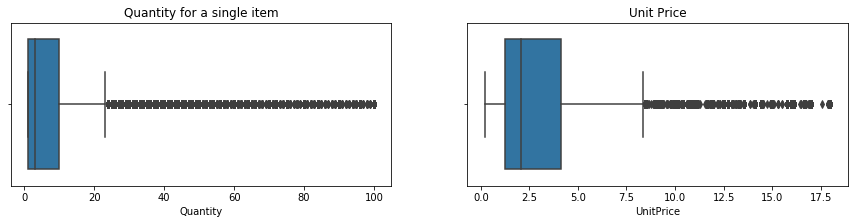

In [42]:
fig,axe = plt.subplots(1,2,figsize = (15,3))
sns.boxplot(transaction['Quantity'],ax=axe[0]);
axe[0].set_title("Quantity for a single item");
sns.boxplot(transaction['UnitPrice'],ax=axe[1]);
axe[1].set_title("Unit Price");

## Distribution of Number of orders per customer

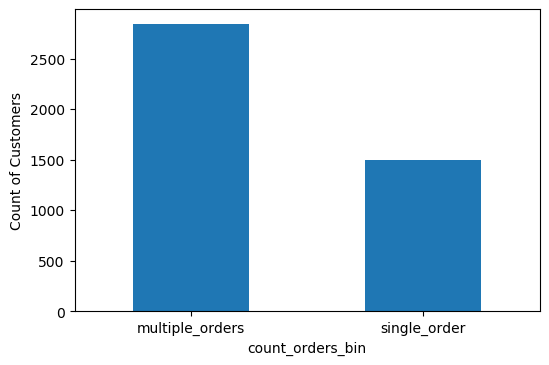

In [278]:
# Remove cancelled transactions from data
mpl.rcParams['figure.dpi']= 100

t1 = transaction[transaction['cancelled_flag']==0]
plotdf = t1.groupby('CustomerID')[['InvoiceNo']].nunique().reset_index().rename(columns={'InvoiceNo':'count_orders'})
plotdf['count_orders_bin'] = plotdf['count_orders'].apply(lambda x: 'single_order' if x==1 else 'multiple_orders')
plotdf.groupby('count_orders_bin')['CustomerID'].nunique().plot(kind='bar',rot=0);
plt.ylabel("Count of Customers")
plt.savefig('Multiple v Single order customers.pdf')

del t1
gc.collect();

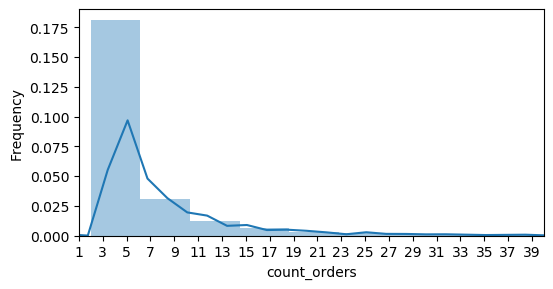

In [91]:
# Distribution for customers with multiple orders
plotdf = plotdf[plotdf['count_orders_bin'] == 'multiple_orders']

mpl.rcParams['figure.dpi']= 100
plt.figure(figsize=(6,3))
sns.distplot(plotdf['count_orders']);
plt.ylabel("Frequency");
plt.xlim([1,40]);
plt.xticks(np.arange(1,40,2));

In [279]:
# Print percentiles
plotdf['count_orders'].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

count    4339.000000
mean        4.271952
std         7.705493
min         1.000000
10%         1.000000
20%         1.000000
30%         1.000000
40%         2.000000
50%         2.000000
60%         3.000000
70%         4.000000
80%         6.000000
90%         9.000000
max       210.000000
Name: count_orders, dtype: float64

## Distribution of cumulative spend over time

In [24]:
# Prepare data for analysis

def amount_calc(row):
    if(row['cancelled_flag']==1):
        return row['Quantity']*row['UnitPrice']*(-1)
    else:
        return row['Quantity']*row['UnitPrice']

transaction['item_amount'] = transaction.apply(amount_calc,axis=1)

# Index days starting from 12/01/2010
sorted_data = transaction.sort_values(by=['InvoiceDate'],ascending='True')
sorted_data['day'] = sorted_data['InvoiceDate'] - pd.to_datetime("12/01/2010",format='%m/%d/%Y')
sorted_data['day'] = sorted_data['day'].dt.days



# Select customers who made their first purchase in the first week of data
t1 = sorted_data.groupby(['CustomerID','day'])[['item_amount']].sum().reset_index()
t1["transaction_sequence"] = t1.groupby('CustomerID')['day'].rank("dense",ascending=True)
cohort = t1[(t1['transaction_sequence']==1) & (t1['day']<=7)][['CustomerID','day']].drop_duplicates().rename(columns={'day':'firstshopday'})

# Select transaction data for the selected cohort

tr_cohort = pd.merge(sorted_data,cohort,how='inner',on='CustomerID')


# select transactions upto 1 year from the first transaction date
tr_cohort['1yrfromfirstshop'] = tr_cohort['firstshopday']+365

tr_cohort_1yr = tr_cohort[tr_cohort['day']<=tr_cohort['1yrfromfirstshop']].copy()

# aggregate sales at a customer, day level

tr_cohort_1yrsummary = tr_cohort_1yr.groupby(['CustomerID','firstshopday','day'])[['item_amount']].sum().reset_index().rename(columns={'item_amount':'sales_value'})

tr_cohort_1yrsummary['DaysAfterFirstShop'] = tr_cohort_1yrsummary['day'] - tr_cohort_1yrsummary['firstshopday']


# Cumulative sales
tr_cohort_1yrsummary['cum_sales'] = tr_cohort_1yrsummary.groupby('CustomerID')['sales_value'].cumsum()


# Total annual sales

annual_sales = tr_cohort_1yrsummary.groupby('CustomerID')[['sales_value']].sum().reset_index().rename(columns={'sales_value':'TOTAL_ANNUAL_SALES'})

tr_cohort_1yrsummary = pd.merge(tr_cohort_1yrsummary,annual_sales,how='left',on='CustomerID')

# Percentage of total annual sales by days after first shop

tr_cohort_1yrsummary['prcnt_sales'] = tr_cohort_1yrsummary['cum_sales']*100/tr_cohort_1yrsummary['TOTAL_ANNUAL_SALES']

# Pivot data by number of days from first shop

tab = tr_cohort_1yrsummary[tr_cohort_1yrsummary['DaysAfterFirstShop']>0][['CustomerID','DaysAfterFirstShop','prcnt_sales']]
tab_wide = tab.pivot(index='DaysAfterFirstShop',columns='CustomerID',values='prcnt_sales').reset_index()
tab_wide.iloc[0,:] = tab_wide.iloc[0,:].replace(np.nan,0)
tab_wide = tab_wide.fillna(method='ffill',axis=0)
tab_wide['Avg_PrcntOfAnnualSales'] = np.mean(tab_wide.iloc[:,1:],axis=1)


# Add prefix to column names

new_names = [(i,'custid_'+i[:-2]) for i in tab_wide.iloc[:, 1:].columns.values]
tab_wide.rename(columns = dict(new_names), inplace=True)

del t1,cohort,tr_cohort,tr_cohort_1yr,tr_cohort_1yrsummary,annual_sales,tab
gc.collect();

In [104]:
del t1,tab
gc.collect();

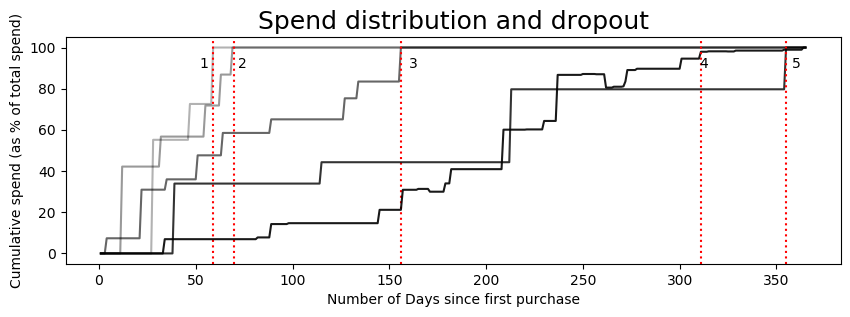

In [101]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

plt.figure(figsize=(10,3));
plt.plot(tab_wide.DaysAfterFirstShop,tab_wide['custid_13963'] ,color='black', alpha=0.3);
plt.annotate('1',xy=(52,90));
plt.axvline(x=59,ymax=100,color='r',ls=':');
plt.plot(tab_wide.DaysAfterFirstShop,tab_wide['custid_16725'] ,color='black', alpha=0.4);
plt.annotate('2',xy=(72,90));
plt.axvline(x=70,ymax=100,color='r',ls=':');
plt.plot(tab_wide.DaysAfterFirstShop,tab_wide['custid_15235'] ,color='black', alpha=0.6);
plt.annotate('3',xy=(160,90));
plt.axvline(x=156,ymax=100,color='r',ls=':');
plt.plot(tab_wide.DaysAfterFirstShop,tab_wide['custid_12557'] ,color='black', alpha=0.8);
plt.annotate('5',xy=(358,90));
plt.axvline(x=355,ymax=100,color='r',ls=':');
plt.plot(tab_wide.DaysAfterFirstShop,tab_wide['custid_17949'] ,color='black', alpha=0.9);
plt.annotate('4',xy=(310,90));
plt.axvline(x=311,ymax=100,color='r',ls=':');
plt.ylabel('Cumulative spend (as % of total spend)')
plt.xlabel('Number of Days since first purchase')
plt.title('Spend distribution and dropout',fontdict={'fontsize':18});

plt.savefig('Cumulative spend Distribution.png')

## Average order value distribution

123728

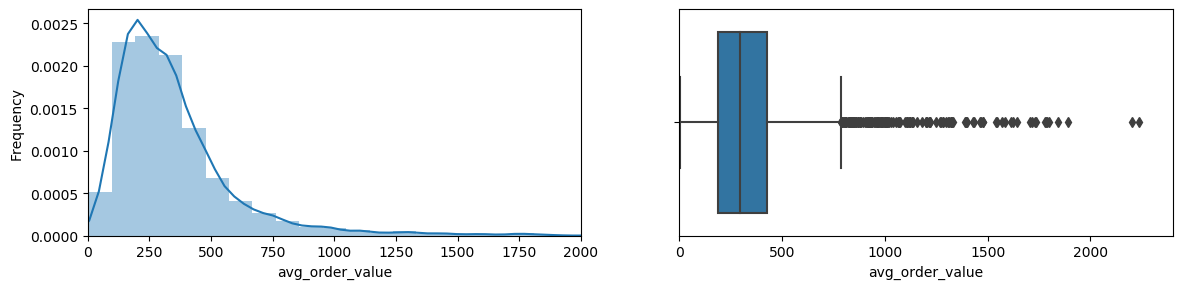

In [135]:
# Prepare data for AOV univariate distribution
cust_inv_value = sorted_data[sorted_data['cancelled_flag']==0].groupby(['CustomerID','InvoiceNo'])[['item_amount']].sum().reset_index().rename(columns={'item_amount':'invoice_amount'})
distdf = cust_inv_value.groupby('CustomerID').agg({'InvoiceNo':'nunique','invoice_amount':'mean'}).reset_index()
distdf.columns = distdf.columns.get_level_values(0)
distdf.columns = ['CustomerID', 'total_orders', 'avg_order_value']
distdf = distdf[distdf['total_orders']>1]

mpl.rcParams['figure.dpi']= 100
fig,axe = plt.subplots(1,2,figsize=(14,3));
sns.distplot(distdf['avg_order_value'],ax=axe[0]);
axe[0].set_xlim([0,2000]);
axe[0].set_ylabel("Frequency");
sns.boxplot(distdf['avg_order_value'],ax=axe[1]);
axe[1].set_xlim([0,2400]);

del cust_inv_value
gc.collect()

### Average order value with transaction sequence

In [280]:
#Prepare data
tab = sorted_data[sorted_data['cancelled_flag'] == 0]
tab['transaction_sequence'] = tab.groupby('CustomerID')['day'].rank("dense",ascending=True)
tab2 = tab.groupby(['transaction_sequence','CustomerID'])[['item_amount']].sum().reset_index().rename(columns={'item_amount':'invoice_amount'})
tab2 = tab2.groupby('transaction_sequence')[['invoice_amount']].mean().reset_index().rename(columns={'invoice_amount':'Avg_order_value'})
plotdf = tab2.copy()
# display(plotdf)

del tab,tab2;
gc.collect();

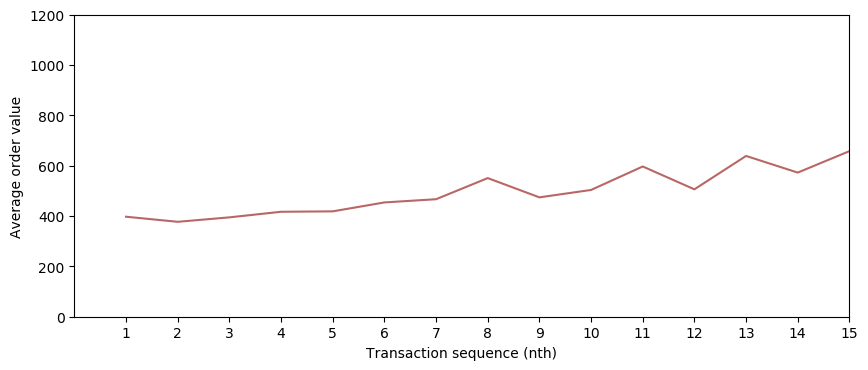

In [174]:
# plt.figure(figsize=(12,4))
# sns.regplot(x=plotdf["transaction_sequence"], y=plotdf["invoice_amount"], fit_reg=True,lowess=True, scatter_kws={"color":"indianred","alpha":0.4,"s":40,"label":"Customer"},line_kws={"color":"darkred","alpha":0.8,"label":"Average line"});
# plt.ylabel('Order value');
# plt.xlabel('Transaction sequence (nth)');
# plt.xlim([0,30]);
# plt.ylim([0,5000]);
# plt.legend();

plt.figure(figsize=(10,4))
sns.lineplot(x=plotdf["transaction_sequence"], y=plotdf["Avg_order_value"],color="darkred",linewidth=1.5,alpha=0.6);
plt.ylabel('Average order value');
plt.xlabel('Transaction sequence (nth)');
plt.xlim([0,15]);
plt.ylim([0,1200]);
plt.xticks(np.arange(1,16,1));

#del plotdf
#gc.collect();

## Average Order Value vs Frequency

In [220]:
# Prepare data for repeat purchasers

sorted_data_noncanc = sorted_data[sorted_data['cancelled_flag']==0]

customer_totalsales = sorted_data_noncanc.groupby('CustomerID')[['item_amount']].sum().reset_index().rename(columns={'item_amount':'total_sales'})

customer_totalorders = sorted_data_noncanc.groupby('CustomerID')[['InvoiceNo']].nunique().rename(columns={'InvoiceNo':'total_orders_placed'})

customer_totalorders['repeat_orders'] = customer_totalorders['total_orders_placed']-1

cust_order_value = pd.merge(customer_totalsales,customer_totalorders,how='inner',on='CustomerID')

cust_order_value['AOV'] = cust_order_value['total_sales']/cust_order_value['total_orders_placed']

cust_order_value.dropna(axis=0,inplace=True)

plotdf = cust_order_value.copy()

plotdf = plotdf[plotdf['repeat_orders']>0]


In [221]:
# Frequency summary
cust_order_value['repeat_orders'].describe()

count    4339.000000
mean        3.271952
std         7.705493
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max       209.000000
Name: repeat_orders, dtype: float64

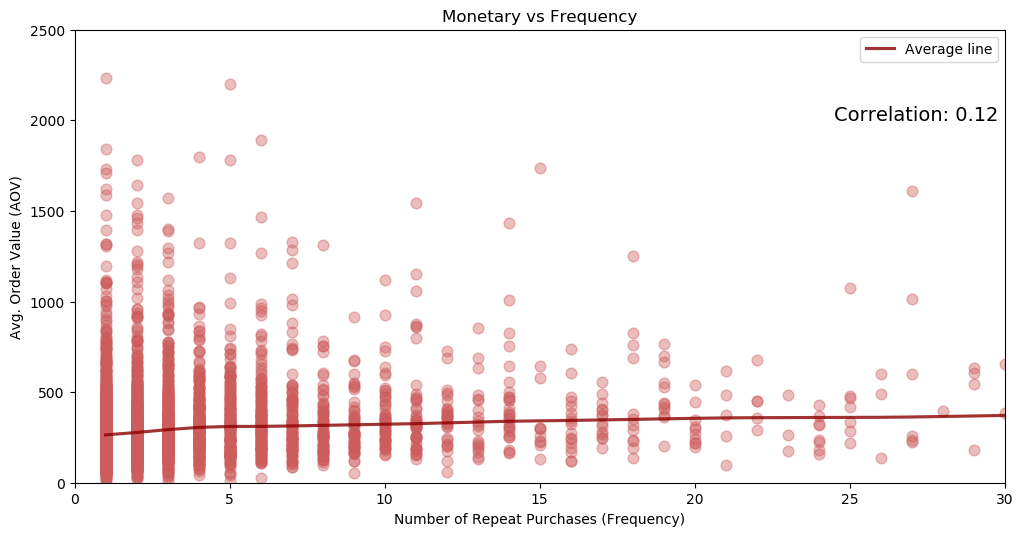

In [240]:
plt.figure(figsize=(12,6))
sns.regplot(x=plotdf["repeat_orders"], y=plotdf["AOV"], fit_reg=True,lowess=True, scatter_kws={"color":"indianred","alpha":0.4,"s":60},line_kws={"color":"darkred","alpha":0.8,"label":"Average line"});
plt.ylabel('Avg. Order Value (AOV)');
plt.xlabel('Number of Repeat Purchases (Frequency)');
plt.title('Monetary vs Frequency');
plt.legend();
plt.xlim([0,30]);
plt.ylim([0,2500]);
plt.annotate("Correlation: 0.12",xy=(24.5,2000),fontsize=14);
plt.savefig("AOVvsFrequency.pdf")

## Frequency vs Recency

In [241]:
# Prepare data

rec1 = sorted_data[sorted_data['cancelled_flag']==0]
rec2 = rec1.groupby('CustomerID').agg({'day':['min','max']}).reset_index()
rec2.columns = rec2.columns.get_level_values(0)
rec2.columns = ['CustomerID', 'min_day', 'max_day']
rec2['recency'] = rec2['max_day'] - rec2['min_day']

rec3 = pd.merge(plotdf,rec2[['CustomerID','recency']],how='inner',on='CustomerID')

del rec1,rec2
gc.collect();

In [223]:
rec3['recency'].describe()

count    2845.000000
mean      199.397891
std       113.872936
min         0.000000
25%        99.000000
50%       208.000000
75%       300.000000
max       373.000000
Name: recency, dtype: float64

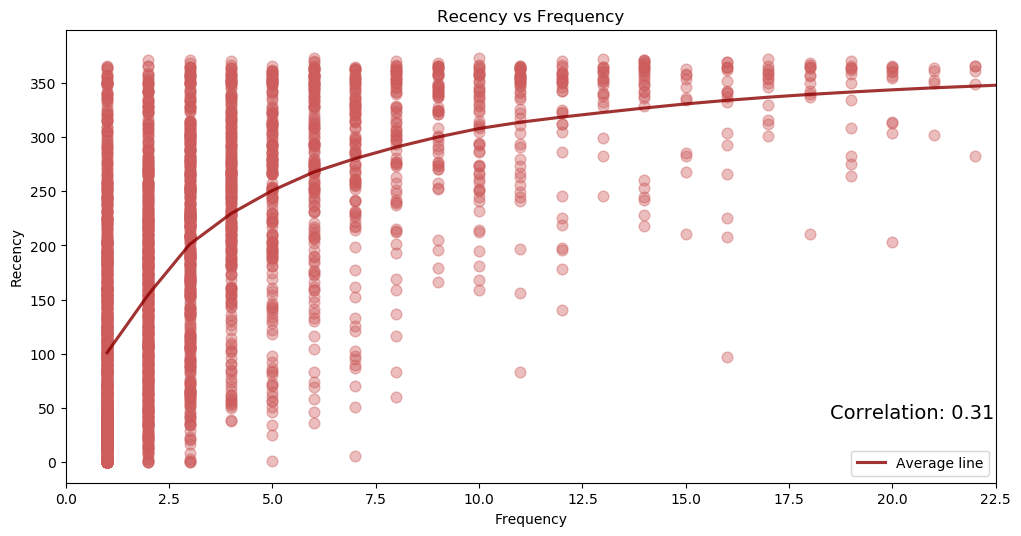

In [259]:
plotdf = rec3.copy()
plt.figure(figsize=(12,6))
sns.regplot(x=plotdf["repeat_orders"], y=plotdf["recency"], fit_reg=True,lowess=True, scatter_kws={"color":"indianred","alpha":0.4,"s":60},line_kws={"color":"darkred","alpha":0.8,"label":"Average line"});
plt.ylabel('Recency');
plt.xlabel('Frequency');
plt.title('Recency vs Frequency');
plt.legend(loc='lower right');
plt.xlim([0,22.5]);
plt.annotate("Correlation: 0.31",xy=(18.5,40),fontsize=14);
plt.savefig("RecencyvsFrequency.pdf")

**Note**: High recency values mean that the customer's last purchase was more recent

## Annual Retention

In [266]:
#Prepare data for monthly churn

# Select transactions from 2011 onwards

dat1 = sorted_data[sorted_data['InvoiceDate']>pd.to_datetime('01/01/2011',format='%m/%d/%Y')]
dat1['invoice_month'] = dat1['InvoiceDate'].dt.month_name()
c1 = dat1[dat1['cancelled_flag']==0]
c1.sort_values(by=['InvoiceDate'],ascending='True',inplace=True)
c1 = c1.groupby(['CustomerID','InvoiceDate','invoice_month'])[['item_amount']].sum().reset_index().rename(columns={'item_amount':'sales_value'})
c1["transaction_sequence"] = c1.groupby('CustomerID')['InvoiceDate'].rank("dense",ascending=True)

def acq_month(row):
    if(row['transaction_sequence']==1.0):
        return row['invoice_month']
    else:
        return np.nan


c1['acquisition_month'] = c1.apply(acq_month,axis=1)
c1['acquisition_month'] = c1['acquisition_month'].fillna(method='ffill',axis=0)

# Pivot

c2 = c1.pivot_table(columns = 'invoice_month',index = 'acquisition_month',values = 'CustomerID',aggfunc = 'nunique')
c2.replace(np.nan,0,inplace = True)

# create churn matrix

c3 = c2.apply(lambda x: x/max(x),axis=1)

# Re-order

new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

c3 = c3.reindex(new_order, axis=0)
c3 = c3.reindex(new_order, axis=1)

# Drop the column for december as transactions only till 9th december are recorded

c3.drop('December',axis=1,inplace = True)

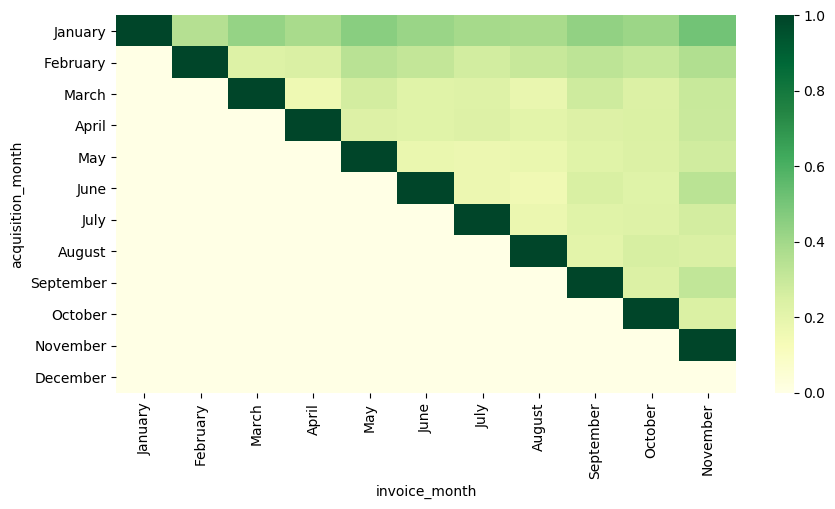

In [267]:
plt.figure(figsize=(10,5))
sns.heatmap(c3,cmap="YlGn");

plt.savefig("monthlyretention.pdf")

del dat1,c1,c2
gc.collect();

In [276]:
display(c3)

invoice_month,January,February,March,April,May,June,July,August,September,October,November
acquisition_month,,,,,,,,,,,
January,1.0,0.353576,0.430499,0.383266,0.457490,0.419703,0.391363,0.384615,0.438596,0.417004,0.514170
February,0.0,1.000000,0.233871,0.247984,0.340726,0.312500,0.272177,0.304435,0.328629,0.308468,0.364919
March,0.0,0.000000,1.000000,0.163265,0.267161,0.222635,0.228200,0.187384,0.283859,0.241187,0.300557
April,0.0,0.000000,0.000000,1.000000,0.235457,0.218837,0.235457,0.210526,0.235457,0.243767,0.296399
May,0.0,0.000000,0.000000,0.000000,1.000000,0.181818,0.175549,0.181818,0.219436,0.241379,0.275862
June,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.175373,0.152985,0.253731,0.223881,0.339552
July,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.178404,0.220657,0.230047,0.267606
August,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.210811,0.254054,0.248649
September,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.240506,0.316456


In [277]:
c4 = c3.mean(axis=1)
display(c4)

acquisition_month
January      0.471844
February     0.337610
March        0.263114
April        0.243264
May          0.206897
June         0.195047
July         0.172429
August       0.155774
September    0.141542
October      0.112970
November     0.090909
December     0.000000
dtype: float64

In [275]:
# Calculate avg. monthly retention rate
print("Monthly average retention rate is: ",np.around(c3.mean().mean()*100,decimals=2),"%")

Monthly average retention rate is:  19.93 %


## Period of purchase

### Orders per month

In [181]:
# Click to see code
pp = rec3.copy()

#filter out customers that have recency = 0 or just a single order

pp = pp[(pp['total_noncancorders']>1) & (pp['recency']>0)]
pp['orders_per_month'] = pp['total_noncancorders']*30/pp['recency']
del rec3
gc.collect();
pp['orders_per_month'].describe()

count    2464.000000
mean        1.934192
std        21.267673
min         0.163934
25%         0.491803
50%         0.753453
75%         1.291018
max      1020.000000
Name: orders_per_month, dtype: float64

In [198]:
# Click to see code

# Map quantiles based on frequency
pp.sort_values(by='total_noncancorders',ascending=True,inplace=True)
pp['frequency_deciles'] = pd.qcut(pp.total_noncancorders, 4)

# Aggregate orders per month and count of customers
pp1 = pp.groupby('frequency_deciles').agg({'orders_per_month':'mean','CustomerID':'nunique'}).reset_index()
pp1.columns = pp1.columns.get_level_values(0)
pp1.columns = ['Total_orders_segment','Avg_orders_per_month','Customer_count']
pp1['total_cust'] = pp1['Customer_count'].sum()
pp1['Segment_population'] = pp1['Customer_count']/pp1['total_cust']

plotdf= pp1

# plt.figure(figsize=(8,5))
# pp.groupby('frequency_deciles')['orders_per_month'].median().plot(kind='bar');
# plt.title("Orders per month across frequency groups");
# plt.xlabel("Total orders (Bins)");
# plt.ylabel("Median orders per month");

del pp,pp1
gc.collect();

NameError: name 'pp' is not defined

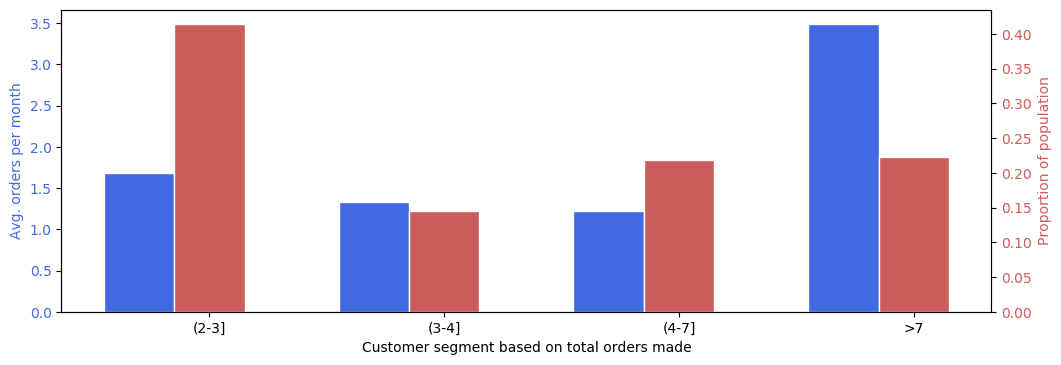

In [208]:
mpl.rcParams['figure.dpi']= 100

#set bar width
barwidth = 0.3
#Set subplot axis - ax1
fig,ax1 = plt.subplots(figsize=(12,4));
ax1.set_xlabel('Customer segment based on total orders made');
ax1.set_ylabel('Avg. orders per month',color='royalblue');
#set positions of bars on x-axis
r1 = np.arange(len(plotdf[['Total_orders_segment']]))
r2 = [x+barwidth for x in r1]
#Make the primary axis plot - ax1
avgorderplot = ax1.bar(r1, 'Avg_orders_per_month', data=plotdf, color = 'royalblue', edgecolor = 'white', width = barwidth);
ax1.tick_params(axis='y',labelcolor = 'royalblue');
#Configure the x-axis tick marks : positions and labels of major ticks
ax1.set_xticks([r + barwidth for r in np.arange(len(plotdf[['Total_orders_segment']]))]);
ax1.set_xticklabels(['(2-3]', '(3-4]', '(4-7]', '>7']);
#Set the secondary axis ax2 - that uses the same x-axis
ax2 = ax1.twinx();
ax2.set_ylabel('Proportion of population',color='indianred');
#Make the secondary axis plot - ax2
proportionplot = ax2.bar(r2, 'Segment_population', data=plotdf, color = 'indianred', edgecolor = 'white', width = barwidth);
ax2.tick_params(axis='y',labelcolor = 'indianred');


plt.savefig('Avg orders per month.pdf')

### Lag between consecutive purchases

In [189]:
# Unfold to check code

# Create a column for the day # of previous transaction
d1 = sorted_data[sorted_data['cancelled_flag'] == 0][['CustomerID','day']].sort_values(by=['CustomerID','day'],ascending=[True,True]).drop_duplicates()
d1['previousorderday'] = d1.groupby('CustomerID')['day'].shift(1)

# Dropping NA rows will remove customers that have only 1 order, and the record for first order of the customer
d1.dropna(axis=0,inplace=True)
d1['lag_days'] = d1['day'] - d1['previousorderday']
d1['lag_days'].describe()

# display()

count    12427.000000
mean        45.649553
std         53.064961
min          1.000000
25%         12.000000
50%         28.000000
75%         58.000000
max        366.000000
Name: lag_days, dtype: float64

In [190]:
del d1;
gc.collect();

# BG-NBD Model  to predict expected number of purchases

## Prepare Data

In [209]:
# Import libraries
from lifetimes import BetaGeoFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix

In [212]:
# Prepare transaction data for input

#0. Filter out all cancellation transactions
sorted_data_noncanc = sorted_data[sorted_data['cancelled_flag']==0]

#1. Remove customers with a single purchase

cust_orders =  sorted_data_noncanc.groupby('CustomerID')[['InvoiceNo']].nunique().reset_index().rename(columns={'InvoiceNo':'cnt_orders'})
single_order_cust = cust_orders[cust_orders['cnt_orders'] >1]
repeat_purchasers = pd.merge(sorted_data_noncanc,single_order_cust[['CustomerID']],how='inner',on='CustomerID')

#2. Convert datetime column to date
repeat_purchasers['InvoiceDate2'] = repeat_purchasers['InvoiceDate'].dt.date
repeat_purchasers['InvoiceDate2'] = pd.to_datetime(repeat_purchasers['InvoiceDate2'])
repeat_purchasers.drop(['InvoiceDate'],axis=1,inplace=True)

#3. Select only customer id and datetime columns
tran = repeat_purchasers[['CustomerID','InvoiceDate2']].drop_duplicates()


del sorted_data_noncanc,cust_orders,single_order_cust,repeat_purchasers
gc.collect();

In [214]:
#Split caliberation and holdout period

calibration_period_ends = '2011-08-31'
summary_cal_holdout = calibration_and_holdout_data(tran, 
                                                   customer_id_col = 'CustomerID', 
                                                   datetime_col = 'InvoiceDate2', 
                                                   freq = 'M', #Months
                                        calibration_period_end=calibration_period_ends,
                                        observation_period_end='2011-12-09' )

In [215]:
summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12347.0,4.0,7.983737,7.983737,2.0,4
12348.0,2.0,3.975441,7.983737,1.0,4
12352.0,1.0,0.919937,5.946734,2.0,4
12356.0,1.0,2.956940,6.965235,1.0,4
12358.0,0.0,0.000000,1.018501,1.0,4


In [216]:
# Remove customers from summary data that do have 0 frequency in caliberation period

,CustomerID,InvoiceDate2
319851,12358.0,2011-07-12
319863,12358.0,2011-12-08


## Fit Model

In [70]:
# Fit Model
bgnbd = BetaGeoFitter(penalizer_coef=0.01)
bgnbd.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'],verbose=True)

Optimization terminated successfully.
         Current function value: -0.144889
         Iterations: 43
         Function evaluations: 44
         Gradient evaluations: 44


<lifetimes.BetaGeoFitter: fitted with 2495 subjects, a: 0.00, alpha: 5.01, b: 0.00, r: 1.83>

In [71]:
bgnbd.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.827409e+00,7.085421e-02,1.688534e+00,1.966283e+00
alpha,5.014083e+00,2.166052e-01,4.589537e+00,5.438629e+00
a,1.007224e-19,1.057109e-13,-2.071933e-13,2.071935e-13
b,2.536411e-05,1.001003e-01,-1.961713e-01,1.962220e-01


## Evaluate Model

compare the caliberation data versus artificial data simulated with the fitted model’s parameters.

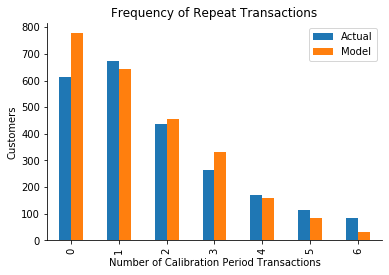

In [59]:
# Access Caliberation Fit

ax = plot_period_transactions(bgnbd, max_frequency=7);
sns.despine();

In [65]:
# Mean Absolute Error - Caliberation
cal_data = summary_cal_holdout[['frequency_cal','recency_cal','T_cal']].copy()



TypeError: conditional_expected_number_of_purchases_up_to_time() missing 1 required positional argument: 'T'